In [14]:
# Davis Kiess
# Code Inquiry Projecet
# Modeling Common Tern Age based on telomere length
# Acknowledgments: Victor Hoppenot, helped merge telo_a.csv, and demo.csv using R

import numpy as np                                     # math functions 
import matplotlib.pyplot as plt                        # graphing results
from sklearn.linear_model import LinearRegression      # has linear regression
from sklearn.ensemble import GradientBoostingRegressor # used to create prediction regions
import pandas as pd                                    # handles data files

In [15]:
# I obtained the data I used to produce my model from the CDC's National Health and Nutrition Examination Survey (NHANES). The NHANES collected telomere data from particpants from 1999 to 2002 and makes them available for everyone to download. I used the data from the 1999-2000 NHANES, so I downloaded TELO_A.XPT, the document containing the telomere data and the reference number of the participant. I also downloaded DEMO.XPT, which contains the age adn partcipant reference number data. 

# Before runnig program, I used the xport python library to convert the dataset from a SAS Transport file (.xpt) to a Comma Sepparated Values file (.csv). 
# I obtained this from the CDC's NHANES, which is free and downloadable by the public, however all of the files are in the .xpt format.
# I needed to do this because python does not have native support for SAS Transport files. Pthon does support .csv files natively.
# I performed this by running some simple command line prompts shown below:

# C:\\Users\Dkiess> pip install xport                           # this installs the xport library to my computer so that I can use it
# C:\\Users\Dkiess> cd Downloads                                # change directories to where my file is stored. I had mine in the downloads folder
# C:\\Users\Dkiess\Downloads> dir                               # this lists all of the files in the current directory. I did this to confirm that my .xpt file was there and its name
# C:\\Users\Dkiess\Downloads> python -m TELO_A.XPT > telo_a.csv # this uses the xport library in python that i installed earlier to convert my file from .xpt to .csv

# This massive .csv file has the data that I will be using, however, it also has a lot of extra data that I will not be using, 
# so I created a new Excel document and copied the columns I needed from the SSAFB file to it.
# These columns were SEQN and TELOMEAN which are the reference number of the person and the T/S ratio of the person. 
# The last step before this file has the telomere data is to convert from T/S ratio to base pairs. The NHANES documentation provides this. The formula is 3274 + 2413x where x is the T/S ratio.
# Next, I need to get the age of the participant from the reference number. This is stored in the Demographics sectino of NHANES, so I downloaded and converted that file. 
# Now I have 2 files, telo_a.csv, which has the telomere data, and demo.csv, which has the age data. Both of these use the SEQN list to show which participant the data is from.
# I enlisted the help of Victor Hoppenot who graciously helped me merge the 2 .csv files into the 'telomeres.csv' file using the R programing language. 
# After merging the files, I deleted all of the extra columns I wasn't using from telomeres.csv. This reduced the size from over 20 MB to under 115 kB in size. 
# Now the data is finally ready to be used in the rest of the program which will be commented with in line comments.


In [16]:
telomeres = pd.read_csv('./telomeres.csv') # store the data in the file in memory
telomeres.corr() # print the correlation matrix of the columns in the data, we are looking for the correlation betweeen RIDAGEYR and TELOBASE (age and telomere length)
# This gives a correlation of -0.400711, which is the border for a  moderate correlation between TELOBASE and RIDAGEYR


,SEQN,RIDAGEYR,TELOMEAN,TELOBASE
SEQN,1.000000,0.008669,0.011201,0.011201
RIDAGEYR,0.008669,1.000000,-0.400711,-0.400711
TELOMEAN,0.011201,-0.400711,1.000000,1.000000
TELOBASE,0.011201,-0.400711,1.000000,1.000000


R^2: 0.16056966637131487 
b0: 6346.688114397101 
b1: [-13.42026078]


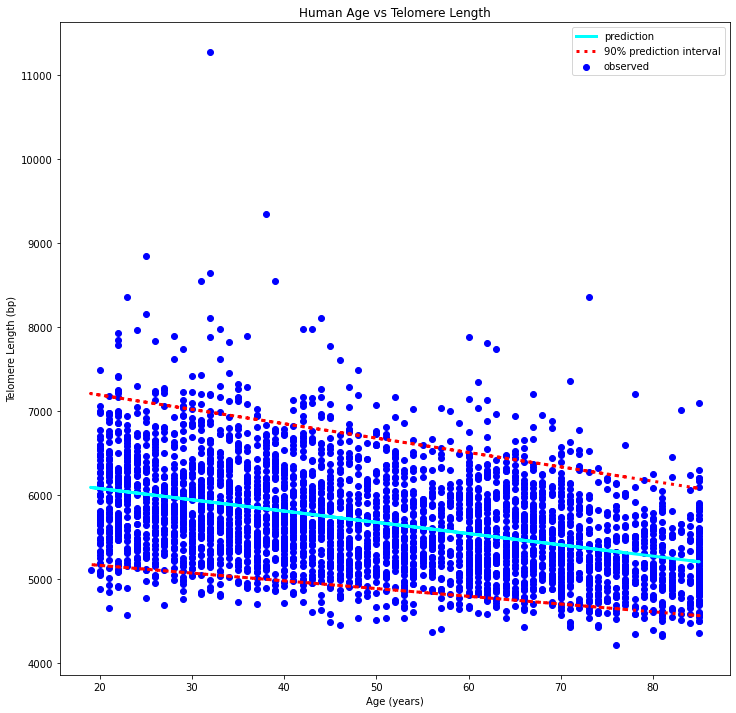

In [17]:
# create the linear regression model

x = (telomeres['RIDAGEYR'].values).reshape(-1,1)     # the x values must be reshaped so that everything is listed as 1 column and as many rows as needed. 
y = telomeres['TELOBASE'].values                     # before it was all in 1 row and as many columns as needed
model = LinearRegression().fit(x, y)                 # create the fit of the data
rr = model.score(x,y)                                # R^2 value of the regression

print('R^2:', rr, '\nb0:', model.intercept_, '\nb1:', model.coef_)

# preditction model
prediction = model.predict(x)

# generating prediction intervals
alpha_low  = 0.05 # 5th percentile
alpha_high = 0.95 # 95th percentile
# These give me the middle 90% of data in the middle

# create upper and lower bound regressions
lower = GradientBoostingRegressor( loss = 'quantile', alpha = alpha_low)
upper= GradientBoostingRegressor( loss = 'quantile', alpha = alpha_high)

# fit upper and lower bound regressions
lower.fit(x,y)
upper.fit(x,y)

# create point predictions based on fits
prediction_lower_points  = lower.predict(x)
prediction_upper_points = upper.predict(x)

# perform linear regression on points to get functions for upper and lower bounds
prediction_lower  = LinearRegression().fit(x, prediction_lower_points).predict(x)
prediction_upper = LinearRegression().fit(x, prediction_upper_points).predict(x)



plt.figure(figsize=(12,12))                # sets the size of the graph
plt.title("Human Age vs Telomere Length")  # sets the title of the graph
plt.ylabel("Telomere Length (bp)")         # sets the label of the y axis
plt.xlabel("Age (years)")                  # sets teh label of the x axis
plt.scatter( telomeres['RIDAGEYR'].values, telomeres['TELOBASE'].values, color='blue', label = 'observed') # graph the telomere length and age data on x-y plane with the color blue
plt.plot(x, prediction, c='cyan', lw =3, label = 'prediction')                                                # graph the mean prediction line of the data
plt.plot(x, prediction_lower, lw = 3, ls = ':', c='red',  label = '90% prediction interval')               # graph the lower bound for the 90% prediction interval
plt.plot(x, prediction_upper, lw = 3, ls = ':', c='red')                                                   # graph the upper bound for the 90% prediction invterval
plt.legend(loc='upper right')                                                                              # show the legend and place it in the top right corner
plt.show()  
